In [ ]:
# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate
from keras.models import Model
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
import numpy as np
import os

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
class MiniGoogLeNet:
  @staticmethod
  def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
    # define a CONV => BN => RELU pattern
    x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)

    # return block
    return x
  
  @staticmethod
  def inception_module(x, numK1x1, numK3x3, chanDim):
    # define two CONV modules, then concatenate across the
    # channel dimension
    conv_1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
    conv_3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis=chanDim)

    # return block
    return x

  @staticmethod
  def downsample_module(x, K, chanDim):
    # define the CONV module and POOL, then concatenate
    # across the channel dimensions
    conv_3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2, 2),
    chanDim, padding="valid")
    pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([conv_3x3, pool], axis=chanDim)

    # return the block
    return x

  @staticmethod
  def build(width, height, depth, classes):
    # initialize the input shape to be "channels last" and the
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    # define the model input and first CONV module
    inputs = Input(shape=inputShape)
    x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

    # two Inception modules followed by a downsample module
    x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
    x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
    x = MiniGoogLeNet.downsample_module(x, 80, chanDim)

    # four Inception modules followed by a downsample module
    x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
    x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
    x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
    x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
    x = MiniGoogLeNet.downsample_module(x, 96, chanDim)

    # two Inception modules followed by global POOL and dropout
    x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
    x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
    x = AveragePooling2D((7, 7))(x)
    x = Dropout(0.5)(x)

    # softmax classifier
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)

    # create the model
    model = Model(inputs, x, name="googlenet")

    # return the constructed network architecture
    return model


In [ ]:
# define the total number of epochs to train for along with the
# initial learning rate
NUM_EPOCHS = 60
INIT_LR = 1e-2

In [ ]:
def poly_decay(epoch):
  # initialize the maximum number of epochs, base learning rate,
  # and power of the polynomial
  maxEpochs = NUM_EPOCHS
  baseLR = INIT_LR
  power = 1.0
  # compute the new learning rate based on polynomial decay
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

  # return the new learning rate
  return alpha

In [ ]:
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,
                         horizontal_flip=True, fill_mode="nearest")

[INFO] loading CIFAR-10 data...


In [ ]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 96)   2688        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 96)   384         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 32, 32, 96)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________

In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=64),
                    validation_data=(testX, testY),
                    steps_per_epoch=len(trainX) // 64, epochs=NUM_EPOCHS,
                    verbose=1)

[INFO] training network...
Epoch 1/60
781/781 [==============================] - 41s 53ms/step - loss: 1.4452 - accuracy: 0.4756 - val_loss: 1.2053 - val_accuracy: 0.5833
Epoch 2/60
781/781 [==============================] - 39s 50ms/step - loss: 1.0214 - accuracy: 0.6365 - val_loss: 0.8776 - val_accuracy: 0.6902
Epoch 3/60
781/781 [==============================] - 39s 50ms/step - loss: 0.8328 - accuracy: 0.7070 - val_loss: 1.3594 - val_accuracy: 0.5744
Epoch 4/60
781/781 [==============================] - 38s 49ms/step - loss: 0.7202 - accuracy: 0.7485 - val_loss: 0.8536 - val_accuracy: 0.7162
Epoch 5/60
781/781 [==============================] - 38s 49ms/step - loss: 0.6456 - accuracy: 0.7782 - val_loss: 0.7809 - val_accuracy: 0.7364
Epoch 6/60
781/781 [==============================] - 38s 49ms/step - loss: 0.5887 - accuracy: 0.7974 - val_loss: 0.6649 - val_accuracy: 0.7730
Epoch 7/60
781/781 [==============================] - 38s 49ms/step - loss: 0.5356 - accuracy: 0.8167 - val_l

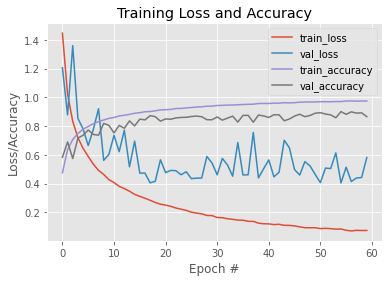

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 60), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)